# DBSCAN clustering to reduce spatial data set size

This notebook reduces the size of a spatial data set by clustering with DBSCAN. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from time import time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle

In [2]:
# load the data set
df = pd.read_csv('data/summer-travel-gps-full.csv')
coordinates = df.as_matrix(columns=['lon', 'lat'])
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


In [3]:
# Compute DBSCAN
# eps is the physical distance from each point that forms its neighborhood
# min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise
start_time = time()
db = DBSCAN(eps=.01, min_samples=1, algorithm='ball_tree', metric='haversine').fit(coordinates)
labels = db.labels_

# number of clusters in labels, ignoring noise if present
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(num_clusters))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coordinates, labels)))
print('Process took {:.02f} seconds'.format(time()-start_time))

Estimated number of clusters: 147
Silhouette coefficient: 0.833
Process took 2.53 seconds


In [4]:
# return the coordinates of the centroid of a numpy array of coordinate points
def get_centroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

In [5]:
# return the point from a set of points that is nearest to the specified point of reference
def get_nearest_point(set_of_points, point_of_reference):
    
    closest_point = None
    closest_dist = None
    
    for point in set_of_points:        
        
        # calculate the great circle distance between points            
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        
        # if this row's nearest is currently null, save this point as its nearest
        # or if this distance is smaller than the previous smallest, update the row
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    
    return closest_point

In [6]:
# now we take one point's coordinates from each cluster that formed
# first, get the clusters
start_time = time()
clusters = pd.Series([coordinates[labels == i] for i in range(num_clusters)])

lat = []
lon = []

# for each cluster, find one representative point from the data set
for _, cluster in clusters.iteritems():
    
    if len(cluster) < 3:
        # if there are only one or two points in the cluster,
        # then just take the first coordinate pair that appears in the cluster's array
        representative_point = (cluster[0][1], cluster[0][0])
        
    else:
        # otherwise, find the point in the cluster that is closest to its centroid
        representative_point = get_nearest_point(cluster, get_centroid(cluster))
    
    lat.append(representative_point[0])
    lon.append(representative_point[1])

cl = pd.DataFrame({'lon':lon, 'lat':lat})
print('process took %s seconds' % round(time() - start_time, 2))
print(len(cl), 'rows in the reduced data set')
cl.head()

process took 0.03 seconds
147 rows in the reduced data set


,lat,lon
0,51.478199,-0.446081
1,38.781775,-9.137544
2,38.771939,-9.128911
3,38.742987,-9.147780
4,38.712325,-9.137434


In [7]:
# return the rows from full_set that have matching 'lat' 'lon' coordinates in the simplified_set
def get_matching_rows(full_set, simplified_set):
    
    start_time = time()

    # fs_label will contain the label of the matching row from the full set
    simplified_set['fs_label'] = None

    # for each coordinate pair in the simplified set
    for si_label, si_row in simplified_set.iterrows():

        si_coords = (si_row['lat'], si_row['lon'])
        # for each coordinate pair in the original full data set
        for fs_label, fs_row in full_set.iterrows():

            # compare tuples of coordinates, if the points match, save this row's label as the matching one
            if si_coords == (fs_row['lat'], fs_row['lon']):
                simplified_set.loc[si_label, 'fs_label'] = fs_label
                break

    # select the rows from the original full data set whose indices appear in fs_label column of the simplified set
    result = full_set.loc[simplified_set['fs_label'].dropna().values]
    print('process took %s seconds' % round(time() - start_time, 2))
    return result

In [8]:
rs = get_matching_rows(df, cl)

process took 7.82 seconds


In [9]:
rs.sort_index(inplace=True)
#rs.to_csv('data/summer-travel-gps-dbscan.csv', index=False)

print('number of points:', len(rs))
rs.tail()

number of points: 147


,lat,lon,date,city,country
1656,37.933913,23.945805,07/06/2014 17:27,Attica,Greece
1662,40.980462,28.820527,07/06/2014 21:27,Istanbul,Turkey
1695,41.014963,29.010762,07/07/2014 16:56,Istanbul,Turkey
1726,41.033193,28.982041,07/08/2014 15:30,Istanbul,Turkey
1756,48.356285,11.791710,07/09/2014 13:17,Munich,Germany


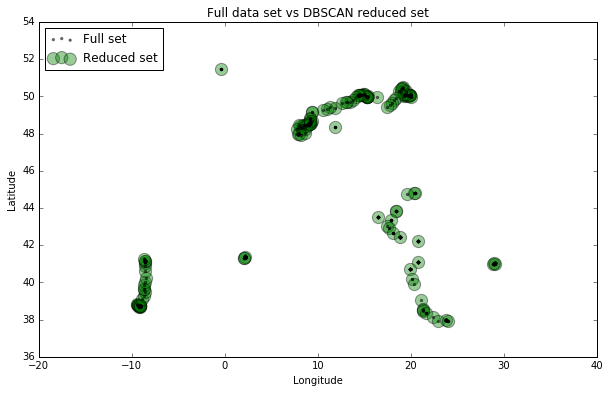

In [10]:
# plot the final reduced set of coordinate points vs the original full set
plt.figure(figsize=(10, 6))
rs_scatter = plt.scatter(rs['lon'], rs['lat'], c='g', alpha=.4, s=150)
df_scatter = plt.scatter(df['lon'], df['lat'], c='k', alpha=.5, s=5)

plt.title('Full data set vs DBSCAN reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()